In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Interactive Machine Learning - Exercise 03

In this exercise we will learn about cooperative machine learning.
Our goal is it to build a very basic cooperative machine learning user interface and use it to extend our Pokedex model from the last exercise.

The steps you are going to cover are as follows:
* Pretrain our Pokedex model with the original data
* Manually label a small bit of new data
* Train our model on the new data
* Use the model in a cooperative workflow to annotate the rest of the dataset

Please read each exercise carefully before you start coding! You will find a number in the comments before each step of coding you will do. Please refer to these numbers if you have any questions.

## 0. Import the libraries
As always we are providing a list useful packages in the import section below.
Keep in mind that you can import additional libraries at any time and that you do not need to use all the imports if you know another solution for a given task.

In [ ]:
import ipywidgets as widgets
import os
import numpy as np
import glob
import random

from matplotlib import pyplot as plt

from IPython.display import Image
from ipywidgets import interact_manual, interact

import keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from shutil import copyfile

## 1. Pretrain the model
In this part we are going to pretrain our model on the pokemon images you already know.
To this end we will use the same VGG16 model as last week with the following training procedure:

Preprocessing:
* Imagesize (224,224)
* Vgg16 standard preprocessing from the Keras framework

Datasplit:
* Use 90% of the data to train and 10% to valitdate your results

Training 1:
* Initialize the model with the imagenet weights
* Freeze all convolution layers
* Train the model using the following settings:
 * 5 Epochs
 * Adam Optimizer with default Parameters
 * categorical cross entropy loss
 * Batchsize 32

Training 2:
*  Unfreeze the last two convolutional Blocks
*  Continue training with the following settings:
 * 10 Epochs
 * Adam Optimizer with a learning rate of 0.0001
 * Batchsize of 32

A convolutional Block in the VGG16 architecture consists of 2 to 3 Conv Layers and on Pooling layer.
You can access a models layer directly via `model.layers`.
Read up on how to freeze layers [here](https://keras.io/guides/transfer_learning/), in case you did not use this technique in the last exercise.
Your model should achieve a validation accuracy of close to 100% .

### 1. Load data for pretraining and apply preprocessing

In [ ]:
PATH = '/content/gdrive/MyDrive/ColabData/pokemons/imgs/*'

IMAGE_SIZE = (224, 224)

X = [image.load_img(file, color_mode='rgb', target_size=IMAGE_SIZE, interpolation='nearest') for file in glob.glob(PATH)]
print("Number of pictures of pokemons: {}, and  two of them just for fun of it : \n{}".format(len(X),X[:3]))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Number of pictures of pokemons: 347, and  two of them just for fun of it : 
[<PIL.Image.Image image mode=RGB size=224x224 at 0x7F93EA383400>, <PIL.Image.Image image mode=RGB size=224x224 at 0x7F93EA383470>, <PIL.Image.Image image mode=RGB size=224x224 at 0x7F93AE83A0B8>]


In [ ]:
X_array = [image.img_to_array(x_, data_format=None, dtype=None) for x_ in X]
print("Number of pictures: in X_array: {}, and shape of one of the pictures {}: ".format(len(X_array),X_array[7].shape))

X_preprocessed =  [preprocess_input(x_) for x_ in X_array]
print("The shape of one of the new preprocessed pictures in X_preprocessed: {} ".format(X_preprocessed[7].shape))

Number of pictures: in X_array: 347, and shape of one of the pictures (224, 224, 3): 
The shape of one of the new preprocessed pictures in X_preprocessed: (224, 224, 3) 


In [ ]:
pokemons = ['bulbasaur', 'charmander', 'eevee', 'flareon', 'jolteon', 'pikachu', 'squirtle', 'vaporeon']

# path is equal to ../input/pokemons/imgs/imgs/*
y = [pokemons.index(x.split('/')[7].split('_')[0].lower()) for x in glob.glob(PATH)]
y_encoded = tf.keras.utils.to_categorical(y, 8)
print("The shape of encoded labels: {}, first three of them: \n{}".format(y_encoded.shape, y_encoded[:3]))

The shape of encoded labels: (347, 8), first three of them: 
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


### 2. Split data into training and test partition

As I understand, we first must ensure that input data is a numpy array

In [ ]:
X_pred_ndarray = np.array(X_preprocessed, dtype=np.float32)
print("The shape of images: {}, and type \n{}".format(X_pred_ndarray.shape, type(X_pred_ndarray)))

The shape of images: (347, 224, 224, 3), and type 
<class 'numpy.ndarray'>


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pred_ndarray, y_encoded, train_size=0.9, random_state=42)
X_train.shape, y_train.shape

((312, 224, 224, 3), (312, 8))



### 3. Define network

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

base_vgg = VGG16(weights="imagenet", include_top = False, input_shape=(224, 224, 3))
base_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### 4. Freeze weights and perform training step 1

In [ ]:
base_vgg.trainable = False

base_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
input_ = Input(shape=(224, 224, 3))

concat_ = base_vgg(input_, training=False)

maxpool_ = MaxPooling2D()(concat_)

flatten_ = Flatten()(maxpool_)

dense_1 = Dense(1024, activation='relu')(flatten_)
dense_2 = Dense(1024, activation='relu')(dense_1)

output_ = Dense(8, activation='softmax', name = 'outupt_eight')(dense_2)

model_vgg = Model(input_, output_)
model_vgg.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4719616   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
outupt_eight (Dense)         (None, 8)                

In [ ]:
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics='acc')

history = model_vgg.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

Epoch 1/5
10/10 [==============================] - 3s 296ms/step - loss: 36.1307 - acc: 0.3878 - val_loss: 10.8153 - val_acc: 0.5429
Epoch 2/5
10/10 [==============================] - 1s 130ms/step - loss: 2.3662 - acc: 0.8462 - val_loss: 2.2419 - val_acc: 0.8000
Epoch 3/5
10/10 [==============================] - 1s 129ms/step - loss: 0.1104 - acc: 0.9712 - val_loss: 2.2480 - val_acc: 0.8571
Epoch 4/5
10/10 [==============================] - 1s 130ms/step - loss: 0.0720 - acc: 0.9904 - val_loss: 1.1071 - val_acc: 0.9143
Epoch 5/5
10/10 [==============================] - 1s 131ms/step - loss: 0.0222 - acc: 0.9968 - val_loss: 0.6943 - val_acc: 0.9429


### 5. Unfreeze weights and perform training step 2

Task is: 
* Unfreeze the last two convolutional Blocks
* Continue training with the following settings:
    * 10 Epochs
    * Adam Optimizer with a learning rate of 0.0001
    * Batchsize of 32

Base model has 19 layers. The last one in it is MaxPooling and two before MaxPooling are Conv2d - exactly what we must set to trainable

In [ ]:
base_vgg.trainable = True
for layer in base_vgg.layers[0:16]:
    layer.trainable =  False
    
base_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model_vgg.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics='acc')

model_vgg.summary()

history = model_vgg.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4719616   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
outupt_eight (Dense)         (None, 8)                

## 2. Pretrain the model
Now that we have our initial model we are going to extend it with some more pokemon.
[Here](https://megastore.uni-augsburg.de/get/OxpI3M_JyU/) you will find roughly 6000 images of the following Pokemon:
* Blastoise
* Charizard
* Charmeleon
* Ivysaur
* Venusaur
* Wartortle

Unfortunately images are not labeled yet. To speed things up a bit we are only going to label a small part of the data ourselves, and then build a model to help us doing the rest.
(Actually this will probably not be faster, but more fun anyway :) ).
In your project directory you will find a 'data_labled' folder, which we will use to store the labeled data.
This time we will use the folder structure to create our labels and train / validation partitions.
Inside the folder you will therefore find a 'train' and an 'val' folder, each of them containing subfolders for each class.

In the following step you should at first manually pick at least 5 examples per class and copy them from the 'data' folder to the train partition of the 'data_labeled' folder.
To then take full advantage of the current way the data is structured, we will use keras data generators in combination with the `flow_from_directory` to dynamically read the input data and feed it to our model.
You can find an example of such data generators [here](https://keras.io/api/preprocessing/image/#flowfromdirectory-method).

Specifically we are going to write a function `train_loop()` which creates two data generators (one for training and one for validation) and trains a model for the new Images on features extracted from our current Pokexedx model.
To this end you can simply rebuild the structure of the original model, but replace the number of output classes.
To load the weights you can then use the following code snippet:
`model.layers[-1]._name = 'new_output'`</br>
`model.load_weights(weight_path, by_name=True)`</br>

Freeze all layers but the dense layers, we will only need those and want to speed up the training process a bit.

### Saving model(for fun) and its weights

In [ ]:
model_vgg.save('model_vgg-pokemons_on_imgs.h5')

model_vgg.save_weights('model_vgg-pokemons_on_imgs_weights.hdf5')

### 6. Copy at least 5 images per class from the data folder to the correct partition in the data_labeled folder

*DONE!*

### 7. Function train_loop()

In [ ]:
def train_loop():
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

    # 8. Build model
    input_ = Input(shape=(224, 224, 3))

    concat_ = base_vgg(input_, training=False)
    maxpool_ = MaxPooling2D()(concat_)
    flatten_ = Flatten()(maxpool_)
    dense_1 = Dense(1024, activation='relu')(flatten_)
    dense_2 = Dense(1024, activation='relu')(dense_1)
    output_ = Dense(6, activation='softmax', name = 'output_six')(dense_2)

    global model
    model = Model(input_, output_)
    model._name = 'train_loop_model'
    """
    print("Model's summary BEFORE loading weights:") 
    model.summary()
    print("BASE Model's summary BEFORE loading weights:")
    base_vgg.summary()
    """
    # 9. Load weights
    print('LOADING WEIGHTS . . .')
    model.load_weights('model_vgg-pokemons_on_imgs_weights.hdf5', by_name = True)

    base_vgg.trainable = False
    """
    print("Model's summary AFTER loading weights: ")
    model.summary()
    print("BASE Model's summary AFTER loading weights:")
    base_vgg.summary()
    """
    
    # 10. Build data generators
    train_data_dir = '/content/gdrive/MyDrive/ColabData/pokemons/data_labeled/train'
    val_data_dir = '/content/gdrive/MyDrive/ColabData/pokemons/data_labeled/val'

    train_datagen = image.ImageDataGenerator()
    val_datagen = image.ImageDataGenerator()

    train_generator = train_datagen.flow_from_directory(
        directory = train_data_dir,
        target_size=(224, 224),
        batch_size=16)

    validation_generator = val_datagen.flow_from_directory(
        directory = val_data_dir,
        target_size=(224, 224),
        batch_size=16)
    print(validation_generator.class_indices)
    # 11. Fit the model to the data for a few epochs
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics='acc')
    
    model.fit_generator(train_generator, validation_data=validation_generator, epochs = 10)

### 12. Call train loop

In [ ]:
train_loop()

LOADING WEIGHTS . . .
Found 31 images belonging to 6 classes.
Found 90 images belonging to 6 classes.
{'Blastoise': 0, 'Charizard': 1, 'Charmeleon': 2, 'Ivysaur': 3, 'Venusaur': 4, 'Wartortle': 5}
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
2/2 [==============================] - 2s 1s/step - loss: 16.8892 - acc: 0.0645 - val_loss: 9.1536 - val_acc: 0.1778
Epoch 2/10
2/2 [==============================] - 1s 314ms/step - loss: 7.5299 - acc: 0.3548 - val_loss: 7.1106 - val_acc: 0.2111
Epoch 3/10
2/2 [==============================] - 1s 454ms/step - loss: 2.4214 - acc: 0.5806 - val_loss: 5.6235 - val_acc: 0.2889
Epoch 4/10
2/2 [==============================] - 1s 341ms/step - loss: 0.4373 - acc: 0.9032 - val_loss: 4.5958 - val_acc: 0.3444
Epoch 5/10
2/2 [==============================] - 1s 415ms/step - loss: 0.0210 - acc: 1.0000 - val_loss: 4.2876 - val_acc: 0.4111
Epoch 6/10
2/2 [==============================] - 1s 321ms/step - loss: 0.0074 

#### Very important note. The dictionary containing the mapping from class names to class indices:
`{'Blastoise': 0, 'Charizard': 1, 'Charmeleon': 2, 'Ivysaur': 3, 'Venusaur': 4, 'Wartortle': 5}`

## 3. Interactive UI

In this part of the exercise we are going to put our pretrained model to good use by employing it in a cooperative workflow.
To this end we gonna build a minimal cooperative machine learning using interface in this python notebook.
Our user interface will consist of the following components:

* (optional) A progressbar to keep to motivation up
* A slider to set a high confidence threshold
* A slider to set the mid confidence threshold
* Some radio buttons to choose the label
* A button to save the annotation and label and show the next image
* A button to retrain our model
* A button to use our model to predict our dataset

The final our UI should look a like this:

![img](https://hcm-lab.de/cloud/index.php/s/ak3txGXepnt9NxS/preview)

The 'retrain' button should call the `train_loop()`  function from before to retrain the model on all labeled data.
The 'predict' button should create a list of predictions for all unlabeled images.
All predictions that are above the high confidence threshold, set by the respective slider, should be automatically accepted as correct label and copied to the respective folders in the training data folder.
Additionally you should implement a garbage label to delete unfitting images.
Potential reasons to consider an Image as garbage are if no Pokemon is visible, too many Pokemon are visible, non of the Pokemon we want to train are visible, the Imagefile is broken etc.
When you are pressing the 'next' button the current image should be copied to the right folder in the training dataset, depending on the current value of the radio button.
Afterwards the next image should be chosen from all predicted images, where the confidence is greater or equal than the value set by the mid_threshold slider.
The current value of the radiobutton should then be set to the prediction for this respective image.
Optionally you can also implement a progressbar to track your progress for you annotations.

You can use the ipywidgets library to create the UI.
You can find an IPython tutorial [here](https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6) and the api documentation [here](https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6).
Note, that Pycharm might not play well with the the widgets in all scenarios. It's best to view them in the browser by visting: http://localhost:8888 after you started your notebook.

### 13. Build UI

#### Creating test set and paths to related images

In [ ]:
path = '/content/gdrive/MyDrive/ColabData/pokemons/data/*'

X = [image.load_img(file, target_size=IMAGE_SIZE, interpolation='nearest') for file in glob.glob(path)]
A = [open(a_, 'rb') for a_ in glob.glob(path)]

##### *A* is path to the image *X*, that is represented as PIL.image (later X_test is derrived from this X-list

In [ ]:
len(X), len(A)

(6081, 6081)

In [ ]:
X_array = [image.img_to_array(x_, data_format=None, dtype=None) for x_ in X]
X_preprocessed =  [preprocess_input(x_) for x_ in X_array]
X_test = np.array(X_preprocessed, dtype=np.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.axes._subplots.AxesSubplot at 0x7f9342228f60>,
 Text(0.5, 1.0, 'YYY'))

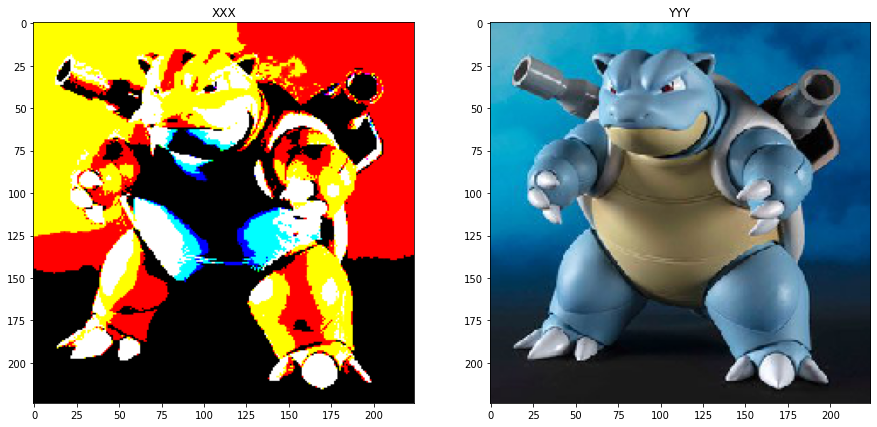

In [ ]:
plt.figure(figsize=(15, 10))
plt.axis("off")

plt.subplot(121), plt.imshow(X_test[2345]), plt.title('XXX')
plt.subplot(122), plt.imshow(X[2345]), plt.title('YYY')

#### Methods to create widgets

In [ ]:
def create_predict_button():    
  button_predict = widgets.Button(description='Predict', button_style='warning')
  button_predict.on_click(on_predict)
  return button_predict

def create_retrain_button():
  button_retrain = widgets.Button(description='Retrain', button_style='danger')
  button_retrain.on_click(on_retrain)
  return button_retrain

def create_next_button():
  button_next = widgets.Button(description='Next', button_style='success')
  button_next.on_click(on_next)
  return button_next

labels = widgets.RadioButtons(options=['Blastoise', 'Charizard', 'Charmeleon', 'Ivysaur', 'Venusaur', 'Wartortle', 'Garbage'],  
                                description='Labels:', disabled=False)

def create_labels_radio():
  return labels

high_conf = widgets.IntSlider(value=95, min=0, max=100, step=5, description='High Conf:', disabled=False, continuous_update=False,
    orientation='horizontal', readout=True, readout_format='d')

def create_high_conf():
  return high_conf

mid_conf = widgets.IntSlider(value=50, min=0, max=100, step=5, description='Mid Conf:', disabled=False, continuous_update=False,
    orientation='horizontal', readout=True, readout_format='d')

def create_mid_conf():
  return mid_conf

def create_image(COUNTER):
  print('Image number is : {}, name : {}'.format(COUNTER, A[COUNTER].name))
  file = open(A[COUNTER].name, "rb")
  image = file.read()
  return widgets.Image(value = image)

#### Collable methods from widgets

In [ ]:
def on_predict(r):
  y_proba = model.predict(X_test)
  print('Prediction is finished. X_test lengths is : ', len(X_test))
  find_conf(y_proba, high_conf.value / 100, mid_conf.value / 100)
  
def on_retrain(r):
  train_loop()

def on_next(label=''):
  global COUNTER
  if labels.value == 'Garbage':
    #X[COUNTER].save('/content/gdrive/MyDrive/ColabData/pokemons/data_labeled/Garbage/' + str(COUNTER) + 'garb.jpg')
    print('This was Garbage')
  else:
    X[COUNTER].save('/content/gdrive/MyDrive/ColabData/pokemons/data_labeled/train/' + labels.value + '/' + str(COUNTER) + 'train.jpg')
    print(COUNTER)
  
  #COUNTER = COUNTER + 1
  del X[COUNTER]
  global X_test
  X_test = np.delete(X_test, COUNTER)
  del A[COUNTER]
  grid[:, 1:] = create_image(COUNTER)

#### **find_conf** method saves images bases on their *probabilities* and *confidence*-variables

In [ ]:
def find_conf(y_proba, high_conf, mid_conf):
  global COUNTER

  # class to index mappings
  class_dict = {0 : 'Blastoise', 1 : 'Charizard', 2 : 'Charmeleon', 3 : 'Ivysaur', 4 :  'Venusaur', 5 : 'Wartortle'}
  # finding maximum prediction and index of that prediction
  max_predictions = []
  index_pred_max = []
  for prediction_ in y_proba:
    pred_ = max(prediction_)
    class_ = np.argmax(prediction_)
    if (pred_ > high_conf) :
      X[COUNTER].save('/content/gdrive/MyDrive/ColabData/pokemons/data_labeled/train/' + class_dict[class_] + '/' + str(COUNTER) + 'train.jpg')
      del X[COUNTER]
      global X_test
      X_test = np.delete(X_test, COUNTER)
      del A[COUNTER]
    
    #COUNTER = COUNTER + 1
  
  print('find_conf is finished. X_test length\'s is now: ', len(X_test))
  # returning next image with confidence lower than COUNTER to the grid
  grid[:, 1:] = create_image(COUNTER)

#### Layout

##### COUNTER counts images

In [ ]:
from ipywidgets import GridspecLayout

global COUNTER
COUNTER = 0

grid = GridspecLayout(9, 4, height='600px')
grid[1, 0] = create_high_conf()
grid[2, 0] = create_mid_conf()
grid[3, 0] = create_labels_radio()
grid[5, 0] = create_next_button()
grid[7, 0] = create_retrain_button()
grid[8, 0] = create_predict_button()
grid[:, 1:] = create_image(COUNTER)

display(grid)

Image number is : 0, name : /content/gdrive/MyDrive/ColabData/pokemons/data/2921.jpg


GridspecLayout(children=(IntSlider(value=95, continuous_update=False, description='High Conf:', layout=Layout(…

This was Garbage


In [ ]:
len(X), COUNTER

(6081, 0)

## 4. repeat(annotate, train, predict)
After you are done creating the UI, we are now going to label the whole dataset together with our model.
To this end use your model to predict and improve iteratively in the following manner:

Set the high confidence slider to a value greater or equal than 0.95 and the mid confidence slider to at least 0.8

Repeat 3 times:

* Call automatic prediction
* Check images that have been above the maximum confidence threshold manually by looking at the content of the respective folders. Make corrections if necessary.
* Annotate remaining images that have been over the mid confidence score
* Retrain you model

Do you notice any change in the amount of images you have to annotate each time?

Repeat till all data is annotated:

* Call automatic prediction
* Annotate remaining images that have been over the mid confidence score
* Retrain you model
* Adjust both confidence scores based on how much you trust your model

Describe your subjective impression of the annotation process. Did you have the feeling, that the cooperative workflow is helpful?

ANSWER:  It is a very helpful tool to manually annotate images that model cannot assign class with desired confidence.

#NOTE! The only things that I didn't include from the GUI-task is *mid_conf*, because I didn't see the reason behind it